# 📊 Basic Graph Analysis in PyTorch Geometric

This notebook loads a graph from a JSON adjacency list, converts it to a PyTorch Geometric graph, and performs basic analysis and visualization.

In [1]:
# 📦 Imports
import json
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import os
from pyvis.network import Network
import numpy as np

In [2]:
# 📁 Load Graph from JSON
with open("chameleon_graph.json") as f:
    adj_dict = json.load(f)

usernames = sorted(adj_dict.keys())
user_to_idx = {u: i for i, u in enumerate(usernames)}
idx_to_user = {i: u for u, i in user_to_idx.items()}

edge_index = []
for user, neighbors in adj_dict.items():
    for neighbor in neighbors:
        edge_index.append([user_to_idx[user], user_to_idx[neighbor]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
x = torch.eye(len(usernames), dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[2277, 2277], edge_index=[2, 62792])


In [3]:
# 📉 Visualize: directed edges + merged bidirectional ones using PyVis

# Convert PyG to directed NetworkX graph
G = to_networkx(data, to_undirected=False)
G = nx.relabel_nodes(G, idx_to_user)

# Create PyVis network
net = Network(notebook=True, directed=True)

# Add nodes and edges
for node in G.nodes():
    net.add_node(node, label=node)

seen=set()

for u, v in G.edges():
    if (v, u) in G.edges():
        pair=tuple(sorted([u, v]))
        if pair not in seen:
            seen.add(pair)
            net.add_edge(pair[0], pair[1], color='grey',arrows="", width=2)

    else:
        net.add_edge(u, v, color='green', width=2, arrowsize=20)

# Generate and display the network
net.show('graph_visualization.html')

graph_visualization.html


print(usernames)
print(idx_to_user)
print(dict(G.in_degree()))

Number of nodes: 2277
Number of Bi-directional edges: 31421
Number of directed edges: -50


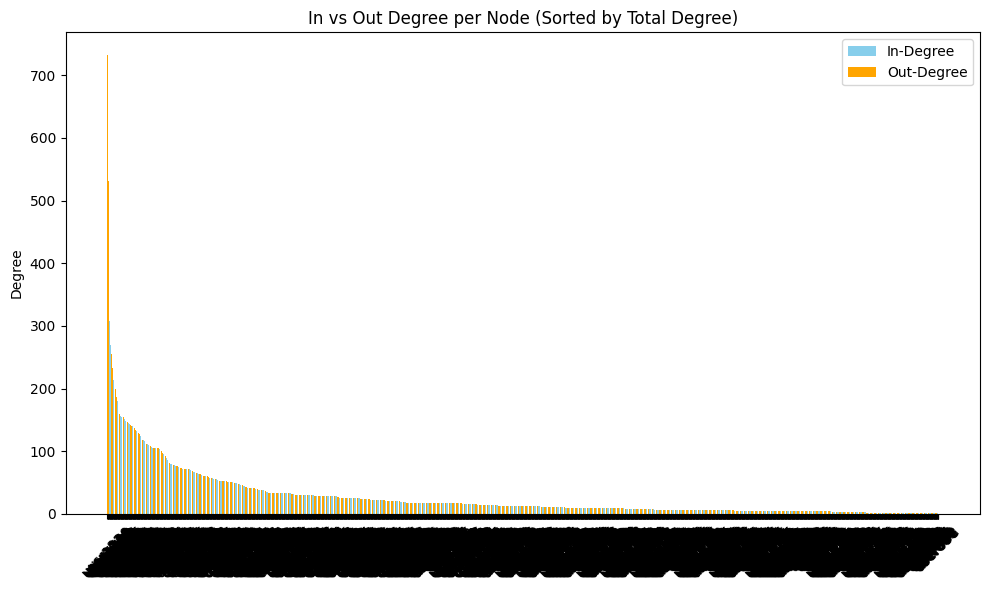

In [4]:
# 📊 Basic Stats
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of Bi-directional edges: {len(seen)}")
print(f"Number of directed edges: {G.number_of_edges() - 2 * len(seen)}")

in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Compute total degree and sort nodes
total_deg = {node: in_deg[node] + out_deg[node] for node in G.nodes()}
sorted_nodes = sorted(total_deg, key=total_deg.get, reverse=True)

# Prepare data
in_values = [in_deg[node] for node in sorted_nodes]
out_values = [out_deg[node] for node in sorted_nodes]
x = np.arange(len(sorted_nodes))

# Plot
bar_width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, in_values, bar_width, label="In-Degree", color="skyblue")
plt.bar(x + bar_width/2, out_values, bar_width, label="Out-Degree", color="orange")

plt.xticks(x, sorted_nodes, rotation=45)
plt.ylabel("Degree")
plt.title("In vs Out Degree per Node (Sorted by Total Degree)")
plt.legend()
plt.tight_layout()
plt.show()